In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
rew_scales = {
    "lin_vel_xy": 6.0,
    "ang_vel_z": 0.5,
    "torque": -0.025,
    "slip": -0.1,
    "balance": -0.025,
    "maxHeight": 0.25,
    "clearance": -20,
}

In [11]:
def summary(func, inp):
    assert isinstance(inp, torch.Tensor)
    if len(inp.shape) == 1:
        inp = inp.unsqueeze(0)
    result = func(inp)
    print(f"min: {result.min().item():.3f}, max: {result.max().item():.3f}, mean: {result.mean().item():.3f}, std: {result.std().item():.3f}")

### Simulation parameters and configurations

- $t_{max}$ = 50: the maximum in-simulation time in seconds in an episode
- $\delta t$ = 0.02: the simulation timestep in seconds
- $\nu_{max}$ = $\frac{t_{max}}{dt}$ = 2500: maximum number of timesteps of an episode

In [12]:
t_max = 50
dt = 0.02
nu_max = t_max/dt

### Linear velocity rewards

The linear velocity reward aims to align the robot's behavior with the user command's velocity in the $xy$ plane. The reward is implemented as the smoothed non-linear scale of the sum of squared differences between the user command and the robot's velocity. The sum of squared differences penalizes larger errors more heavily than smaller ones, which encourages accuracy, while the exponential function transforms the linear velocity error into a non-linear scale. For small errors, the reward remains relatively high, but as errors increase, the reward decreases rapidly. This characteristic encourages the agent to minimize error but does so in a way that is not overly punitive for small deviations.

Given the robot's velocity vector in the $xy$ plane $\vec{v_R}$ and the user input's desired velocity vector $\vec{v_C}$, the reward $r_{vel}$ is implemented in the equations 1 and 2, where $K_{vel}$ is the scaling factor, and $\alpha_{vel}$ is the sensitivity scale of the reward.

\begin{equation}
\epsilon_v = (\vec{v_C} - \vec{v_R}) \cdot (\vec{v_C} - \vec{v_R})
\tag{1}
\end{equation}

\begin{equation}
r_{vel} = K_{vel} e^{\frac{-\epsilon_v}{\alpha_{vel}}}
\tag{2}
\end{equation}

where, $K_{vel} = \tilde{K}_{vel} dt$.

The reward is maximed when $\vec{v_C} = \vec{v_R}$, giving a value exactly equal to $K_{vel}$. The theorical minimum value of the reward is 0 when $\vec{v_C} = -\vec{v_R}$ and $\vec{v_C}$ is an infinetly large vector. In practice, however, since the command values are finite and often in the range of $[-2, 2]$, the minimum value may vary due simulation parameters.


In [13]:
def lin_vel_xy_reward(base_lin_vel, commands, rew_scales = {"lin_vel_xy": 6*dt, "smoothness_vel": 0.25}):
    lin_vel_error = torch.sum(torch.square(commands[:,:2] - base_lin_vel[:,:2]), dim=-1)
    rew_lin_vel_xy = torch.exp(-lin_vel_error/rew_scales["smoothness_vel"]) * rew_scales["lin_vel_xy"]
    return rew_lin_vel_xy

As of latest, the default values for $\tilde{K}_{vel}$ and $\alpha_{vel}$ are $6.0$ and $0.25$ respectively. However, the simulation also scales the multiplication factors such as $\tilde{K}_{vel}$ by the timestep size. Therefore, with a step size of $0.02$, we get a $K_{vel} = 0.12$.

 Considering a command velocity range of $[-2, 2]$, an agent velocity range of $[-4, 4]$ and a timestep range of $[0, \nu_{max}]$, we can plot the possible values of the linear velocity reward in different steps of the episode.

In [14]:
command_range = torch.arange(-2, 2, 0.01)
base_lin_vel_range = torch.arange(-4, 4, 0.02)
commands = torch.stack(torch.meshgrid(command_range, command_range), dim=-1).reshape(-1, 2)
base_lin_vel = torch.stack(torch.meshgrid(base_lin_vel_range, base_lin_vel_range), dim=-1).reshape(-1, 2)

summary(lambda x: lin_vel_xy_reward(x, commands), base_lin_vel)

min: 0.000, max: 0.120, mean: 0.006, std: 0.018


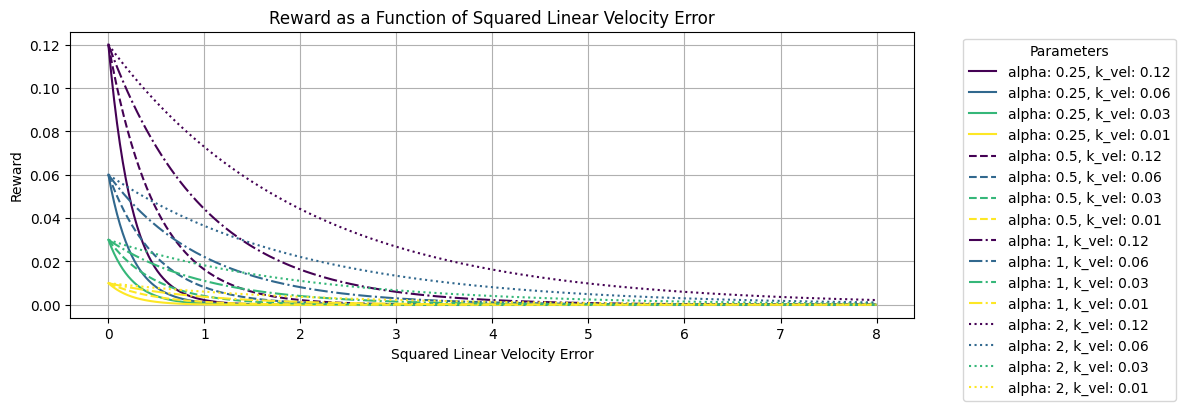

In [17]:
alphas = [0.25, 0.5, 1, 2]
k_vels = np.array([6, 3, 1.5, 0.5])*dt
line_styles = ['-', '--', '-.', ':'] 
colors = plt.cm.viridis(np.linspace(0, 1, len(k_vels))) 

plt.figure(figsize=(12, 4))

for i, alpha in enumerate(alphas):
    for j, k_vel in enumerate(k_vels):
        lin_vel_error_range = torch.arange(0, (2**2 + 2**2), 0.01)
        rew_lin_vel_xy = torch.exp(-lin_vel_error_range/alpha) * k_vel
        plt.plot(lin_vel_error_range, rew_lin_vel_xy, label=f"alpha: {alpha}, k_vel: {k_vel}",
                 linestyle=line_styles[i], color=colors[j])

plt.xlabel('Squared Linear Velocity Error')
plt.ylabel('Reward')
plt.title('Reward as a Function of Squared Linear Velocity Error')
plt.legend(title="Parameters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

We can then calculate the maximum possible value value of the reward function by the following equation:

\begin{equation}
r_{vel}^{max} = \tilde{K}_{vel}\delta t\nu_{max}
\end{equation}

Applying $\tilde{K}_{vel} = 6.0$, $\delta t = 0.02$ and $\nu_{max} = 2500$, we get a maximum value of $r_{vel}^{max} = 300$. The latest training simulations show that this reward plateaus at around 250, which is coherent with this calculation, as it's unlikely the agent will always have 0 squared velocity error.

![velocity reward 22-01-2024](./images/simulation_r_vel_22-01-2024.png)

### Torque reward

The torque reward penalizes the agent's torque for each movement. This aims to encourage the agent to perform efficient joint movements and punish exagerated gaits, optimizing energy utilization. The reward is implemented as the sum of squared torques $\tau_i$ of all 6 joints. A negative constant $K_{torque}$ is applied to the resulting function, giving it an always negative signal. 


\begin{equation}

r_{torque} = K_{torque} \sum_{i=1}^{6} \tau_i^2 

\tag{3}
\end{equation}

In [37]:
def compute_rewards(commands, base_lin_vel, base_ang_vel, torques, contact_forces, foot_positions, foot_velocities, episode_lengths):
    lin_vel_error = torch.sum(torch.square(commands[:2] - base_lin_vel[:2]), dim=-1)
    ang_vel_error = torch.square(commands[2] - base_ang_vel[2])
    rew_lin_vel_xy = torch.exp(-lin_vel_error/0.25) * rew_scales["lin_vel_xy"]
    rew_ang_vel_z = torch.exp(-ang_vel_error/0.25) * rew_scales["ang_vel_z"]


    # torque penalty
    rew_torque = torch.sum(torch.square(torques), dim=-1) * rew_scales["torque"]


    # foot slip penalty (solo 12 article)
    contact = torch.norm(contact_forces) > 1
    rew_slip = torch.sum(contact * torch.square(torch.norm(foot_velocities[:2])), dim = -1) * rew_scales["slip"]

    #keep balance r = -0.015*(vitesse_rot_base_x²+vitesse_rot_base_y²)
    rew_balance = torch.sum(torch.square(base_ang_vel[:2]), dim=-1) * rew_scales["balance"]

    # foot clearance penalty (solo 12 article)
    rew_clearance = torch.sum(torch.square(foot_positions[:2] - rew_scales["maxHeight"]) * torch.sqrt(torch.norm(foot_velocities[:2])), dim = -1) * rew_scales["clearance"]

    rew_air_time = 0.0025/(1 + torch.exp(-episode_lengths/0.5))

    return {
        "lin_vel_xy": rew_lin_vel_xy,
        "ang_vel_z": rew_ang_vel_z,
        "torque": rew_torque,
        "slip": rew_slip,
        "balance": rew_balance,
        "clearance": rew_clearance,
        "air_time": rew_air_time,
        "total": rew_lin_vel_xy + rew_ang_vel_z + rew_torque + rew_slip + rew_balance + rew_clearance + rew_air_time,
    }

def summarize_rewards(rewards, title=None, episode_length=500):
    if title is not None:
        print(f"======== Summary of {title} for 1 environment step =========")
    for key, value in rewards.items():
        print(f"{key}: {value.mean().item():.3f} +/- {value.std().item():.3f}")
    print(f"Total: {rewards['total'].mean().item():.3f} +/- {rewards['total'].std().item():.3f}")
    print(f"======== Summary of {title} for 1 episode =========")
    for key, value in rewards.items():
        print(f"{key}: {value.item()*episode_length:.3f}")
    print("======================================================\n\n")

    

In [38]:
commands_max = torch.cat((velocity_max, ang_vel_max))
commands_min = torch.cat((velocity_max, ang_vel_max))

max_rewards = compute_rewards(commands_max, velocity_max, ang_vel_max, torque_max, contact_forces_max, foot_positions_max, foot_velocities_max, episode_length_max)
min_rewards = compute_rewards(commands_min, velocity_min, ang_vel_min, -torque_max, contact_forces_min, foot_positions_min, foot_velocities_min, torch.tensor(0))


summarize_rewards(max_rewards, "max values", episode_length_max)
summarize_rewards(min_rewards, "min values", episode_length_max)

======== Summary of max values for 1 environment step =========
lin_vel_xy: 6.000 +/- nan
ang_vel_z: 0.500 +/- nan
torque: -0.006 +/- nan
slip: 0.000 +/- nan
balance: 0.000 +/- nan
clearance: -2.102 +/- nan
air_time: 0.002 +/- nan
total: 4.394 +/- nan
Total: 4.394 +/- nan
======== Summary of max values for 1 episode =========
lin_vel_xy: 15000.000
ang_vel_z: 1250.000
torque: -15.625
slip: -0.000
balance: -0.000
clearance: -5255.603
air_time: 6.250
total: 10985.022


======== Summary of min values for 1 environment step =========
lin_vel_xy: 0.000 +/- nan
ang_vel_z: 0.500 +/- nan
torque: -0.006 +/- nan
slip: 0.000 +/- nan
balance: 0.000 +/- nan
clearance: -2.102 +/- nan
air_time: 0.001 +/- nan
total: -1.607 +/- nan
Total: -1.607 +/- nan
======== Summary of min values for 1 episode =========
lin_vel_xy: 0.000
ang_vel_z: 1250.000
torque: -15.625
slip: -0.000
balance: -0.000
clearance: -5255.603
air_time: 3.125
total: -4018.103




In [28]:


for name, value in max_rewards.items():
    print(f"{name}: {value}")

lin_vel_xy: 6.0
ang_vel_z: 0.5
torque: -0.0062500000931322575
slip: -0.0
balance: -0.0
clearance: -2.102241039276123
air_time: 0.0024999999441206455
total: 4.394009113311768
